In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [3]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLNtoControl_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Process for motif calling with Homer

In [4]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

In [5]:
atac_peaks = pd.read_csv('./kc_amln_atac_peaks_all.txt', sep='\t', index_col=0)

Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [5]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

# Extract differential peaks

In [6]:
if not os.path.isdir('./nash_activated_peaks'):
    os.mkdir('./nash_activated_peaks')
    
if not os.path.isdir('./nash_repressed_peaks'):
    os.mkdir('./nash_repressed_peaks')

This code will read in each of the differential output files and select activated and repressed peaks according to the fold change cutoffs shown below.  

Next it writes out the activated and repressed peaks as well as a background peak set (all peaks that are not activated and repressed) that can be used as an improved background over randomly generated sequences for HOMER motif analysis.

In [7]:
# set p value and log2fc
padj = 0.05
log2fc = 1

peak_dict = {}

for i in glob.glob('./*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './ann_norm_kc_amln_atac_peaks_all.txt')
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # write out peaks
    # active peaks
    atac_peaks_200bp.loc[act, :].to_csv(
        './nash_activated_peaks/'+i.split('_')[0]+'_act_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak.index.difference(act), :].to_csv(
        './nash_activated_peaks/'+i.split('_')[0]+'_bg_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
    
    # repressed peaks 
    atac_peaks_200bp.loc[rep, :].to_csv(
        './nash_repressed_peaks/'+i.split('_')[0]+'_rep_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak.index.difference(rep), :].to_csv(
        './nash_repressed_peaks/'+i.split('_')[0]+'_bg_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    peak_dict[i.split('_')[0].replace('./','')] = [act, rep]
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    actd = diff_peak_distal.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak_distal.iloc[:, -1] < padj), :].index.tolist()
    repd = diff_peak_distal.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak_distal.iloc[:, -1] < padj), :].index.tolist()
    
    # write out peaks
    # active peaks
    atac_peaks_200bp.loc[actd, :].to_csv(
        './nash_activated_peaks/'+i.split('_')[0]+'_act_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak_distal.index.difference(actd), :].to_csv(
        './nash_activated_peaks/'+i.split('_')[0]+'_bg_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
    
    # repressed peaks 
    atac_peaks_200bp.loc[repd, :].to_csv(
        './nash_repressed_peaks/'+i.split('_')[0]+'_rep_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')
        
    # active peaks background
    atac_peaks_200bp.loc[diff_peak_distal.index.difference(repd), :].to_csv(
        './nash_repressed_peaks/'+i.split('_')[0]+'_bg_distal_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt',
        sep='\t')

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


### Call motifs using homer

In [31]:
%%bash
# delete the existing script file
rm ./findMotifs_homer.sh
# create a script file
touch ./findMotifs_homer.sh

In [32]:
%%bash
for i in ./nash_activated_peaks/*act*;
do bg_file=${i/_act_/_bg_};
out=${i/.txt/_motifs}
out=${out/nash_activated_peaks/motif_calling};
echo "findMotifsGenome.pl $i mm10 $out -bg $bg_file -len 8,10,12,14,16 -size given &" >> ./findMotifs_homer.sh
done

for i in ./nash_repressed_peaks/*rep*;
do bg_file=${i/_rep_/_bg_};
out=${i/.txt/_motifs}
out=${out/nash_repressed_peaks/motif_calling};
echo "findMotifsGenome.pl $i mm10 $out -bg $bg_file -len 8,10,12,14,16 -size given &" >> ./findMotifs_homer.sh
done

In [92]:
strain_ind_dict = {'aj': 'AJ',
                   'balbc': 'BALBCJ'}

with open('./findMotifs_marge.sh', 'w') as f:
    # loop over activated peaks
    for i in np.sort(glob.glob('./nash_activated_peaks/*act*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_activated_peaks', 'motif_calling').replace('.txt', '_marge_motifs'),
                          '-bg', i.replace('_act_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_ind_dict[strain],
                          '-bg_ind', strain_ind_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))
            
    for i in np.sort(glob.glob('./nash_repressed_peaks/*rep*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_repressed_peaks', 'motif_calling').replace('.txt', '_marge_motifs'),
                          '-bg', i.replace('_rep_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_ind_dict[strain],
                          '-bg_ind', strain_ind_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))

./nash_activated_peaks/aj_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/aj_act_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_peaks_p_0.05_log2fc_1.txt


In [93]:
strain_ind_dict = {'aj': 'BALBCJ',
                   'balbc': 'AJ'}

with open('./findMotifs_marge_mismatched.sh', 'w') as f:
    # loop over activated peaks
    for i in np.sort(glob.glob('./nash_activated_peaks/*act*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_activated_peaks', 'motif_calling').replace('.txt', '_marge_motifs_mismatched'),
                          '-bg', i.replace('_act_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_ind_dict[strain],
                          '-bg_ind', strain_ind_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))
            
    for i in np.sort(glob.glob('./nash_repressed_peaks/*rep*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_repressed_peaks', 'motif_calling').replace('.txt', '_marge_motifs_mismatched'),
                          '-bg', i.replace('_rep_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_ind_dict[strain],
                          '-bg_ind', strain_ind_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))

./nash_activated_peaks/aj_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/aj_act_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_peaks_p_0.05_log2fc_1.txt


In [94]:
strain_ind_dict = {'aj': 'SPRETEIJ',
                   'balbc': 'SPRETEIJ'}

with open('./findMotifs_marge_spret.sh', 'w') as f:
    # loop over activated peaks
    for i in np.sort(glob.glob('./nash_activated_peaks/*act*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_activated_peaks', 'motif_calling').replace('.txt', '_marge_motifs_spret'),
                          '-bg', i.replace('_act_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_ind_dict[strain],
                          '-bg_ind', strain_ind_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))
            
    for i in np.sort(glob.glob('./nash_repressed_peaks/*rep*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_repressed_peaks', 'motif_calling').replace('.txt', '_marge_motifs_spret'),
                          '-bg', i.replace('_rep_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_ind_dict[strain],
                          '-bg_ind', strain_ind_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))

./nash_activated_peaks/aj_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/aj_act_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_peaks_p_0.05_log2fc_1.txt


In [55]:
strain_fg_dict = {'aj': 'SPRETEIJ',
                  'balbc': 'SPRETEIJ'}
strain_bg_dict = {'aj': 'AJ',
                  'balbc': 'BALBCJ'}

with open('./findMotifs_marge_spret_fg.sh', 'w') as f:
    # loop over activated peaks
    for i in np.sort(glob.glob('./nash_activated_peaks/*act*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_activated_peaks', 'motif_calling').replace('.txt', '_marge_motifs_spret'),
                          '-bg', i.replace('_act_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_fg_dict[strain],
                          '-bg_ind', strain_bg_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))
            
    for i in np.sort(glob.glob('./nash_repressed_peaks/*rep*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_repressed_peaks', 'motif_calling').replace('.txt', '_marge_motifs_spret'),
                          '-bg', i.replace('_rep_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_fg_dict[strain],
                          '-bg_ind', strain_bg_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))

./nash_activated_peaks/aj_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/aj_act_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_peaks_p_0.05_log2fc_1.txt


In [56]:
strain_bg_dict = {'aj': 'SPRETEIJ',
                  'balbc': 'SPRETEIJ'}
strain_fg_dict = {'aj': 'AJ',
                  'balbc': 'BALBCJ'}

with open('./findMotifs_marge_spret_bg.sh', 'w') as f:
    # loop over activated peaks
    for i in np.sort(glob.glob('./nash_activated_peaks/*act*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_activated_peaks', 'motif_calling').replace('.txt', '_marge_motifs_spret'),
                          '-bg', i.replace('_act_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_fg_dict[strain],
                          '-bg_ind', strain_bg_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))
            
    for i in np.sort(glob.glob('./nash_repressed_peaks/*rep*')):
        if 'C57' not in i:
            print(i)
            strain = i.split('/')[-1].split('_')[0]
            motif_call = ['/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs', i, 'mm10',
                          i.replace('nash_repressed_peaks', 'motif_calling').replace('.txt', '_marge_motifs_spret'),
                          '-bg', i.replace('_rep_', '_bg_'),
                          '-len 8,10,12,14,16', '-size given',
                          '-fg_ind', strain_fg_dict[strain],
                          '-bg_ind', strain_bg_dict[strain],
                          '&\n\n']
            f.write(' '.join(motif_call))

./nash_activated_peaks/aj_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/aj_act_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_distal_peaks_p_0.05_log2fc_1.txt
./nash_activated_peaks/balbc_act_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/aj_rep_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_distal_peaks_p_0.05_log2fc_1.txt
./nash_repressed_peaks/balbc_rep_peaks_p_0.05_log2fc_1.txt


# Aggregate results - Homer

In [10]:
np.sort(glob.glob('./motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge*/knownResults.txt'))

array(['./motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
       './motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge_motifs_mismatched/knownResults.txt',
       './motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge_motifs_spret/knownResults.txt'],
      dtype='<U92')

# Check functioning of Marge De Novo Motifs
Ty is concerned that marge is not shifting properly. As a preliminary test I ran three versions of the same command.
1. motif analysis shifting aj and balb according to proper background strain.
2. motif analysis shifting aj and balb according to mismatched strain (aj shifted according to balb and reverse)
3. motif analysis shifting aj and balb according to spret (highly divergent strain)

Now we will check whether Marge de novo motifs produces different results when we use different shifting vectors

In [11]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge*/knownResults.txt')):
    if 'distal' in f:    
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.iloc[:, 2]

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())


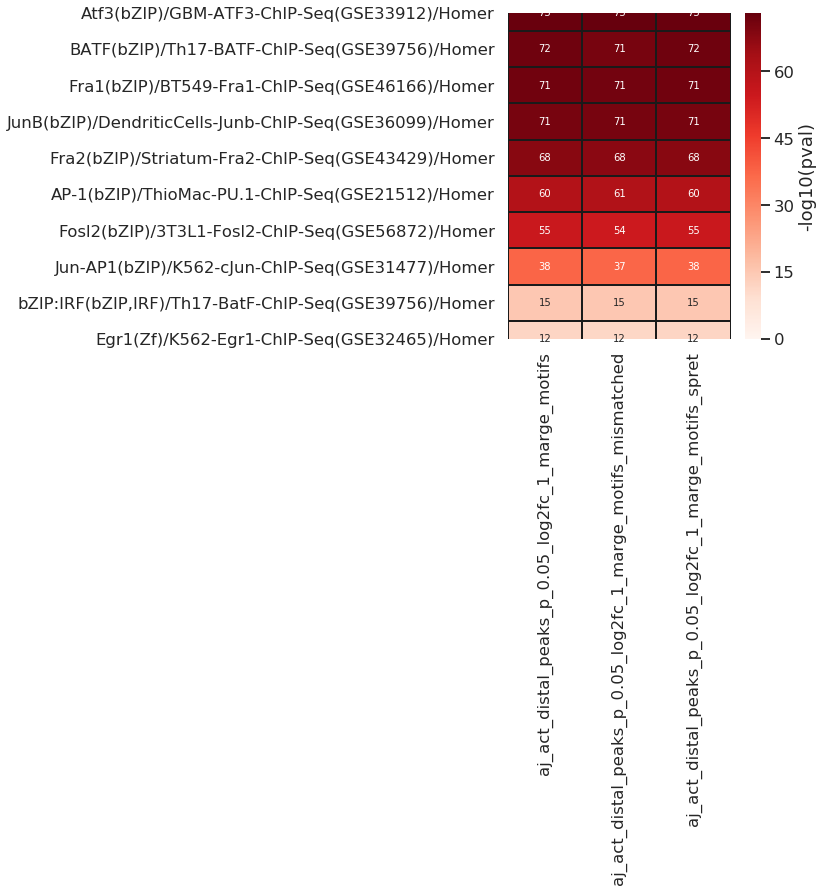

In [12]:
fig, ax = plt.subplots(figsize=(5,6))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=np.log10(0.00001)).any(axis=1), :].head(10),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)

Now check correlation between all motifs

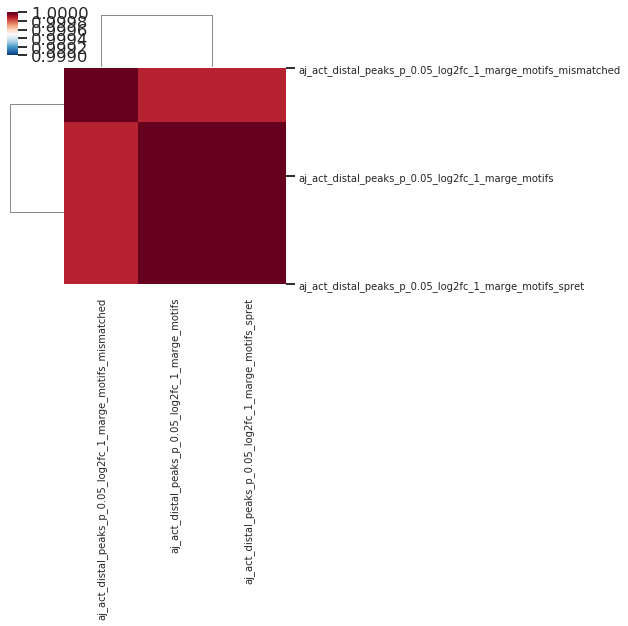

In [17]:
g = sns.clustermap(known_motif_pval_frame.corr(),
            cmap='RdBu_r',
            vmin=0.999,
            figsize=(5,5));
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(),
                             fontsize = 10);
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(),
                             fontsize = 10);

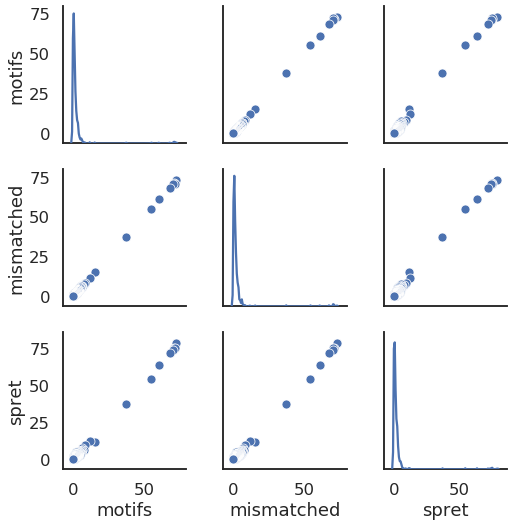

In [54]:
known_motif_pval_frame.columns = known_motif_pval_frame.columns.str.split('_').str[-1]
g = sns.PairGrid(-known_motif_pval_frame)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)

### Compare correlations across all samples

In [18]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*marge*/knownResults.txt')):
    if 'distal' in f:    
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.iloc[:, 2]

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())


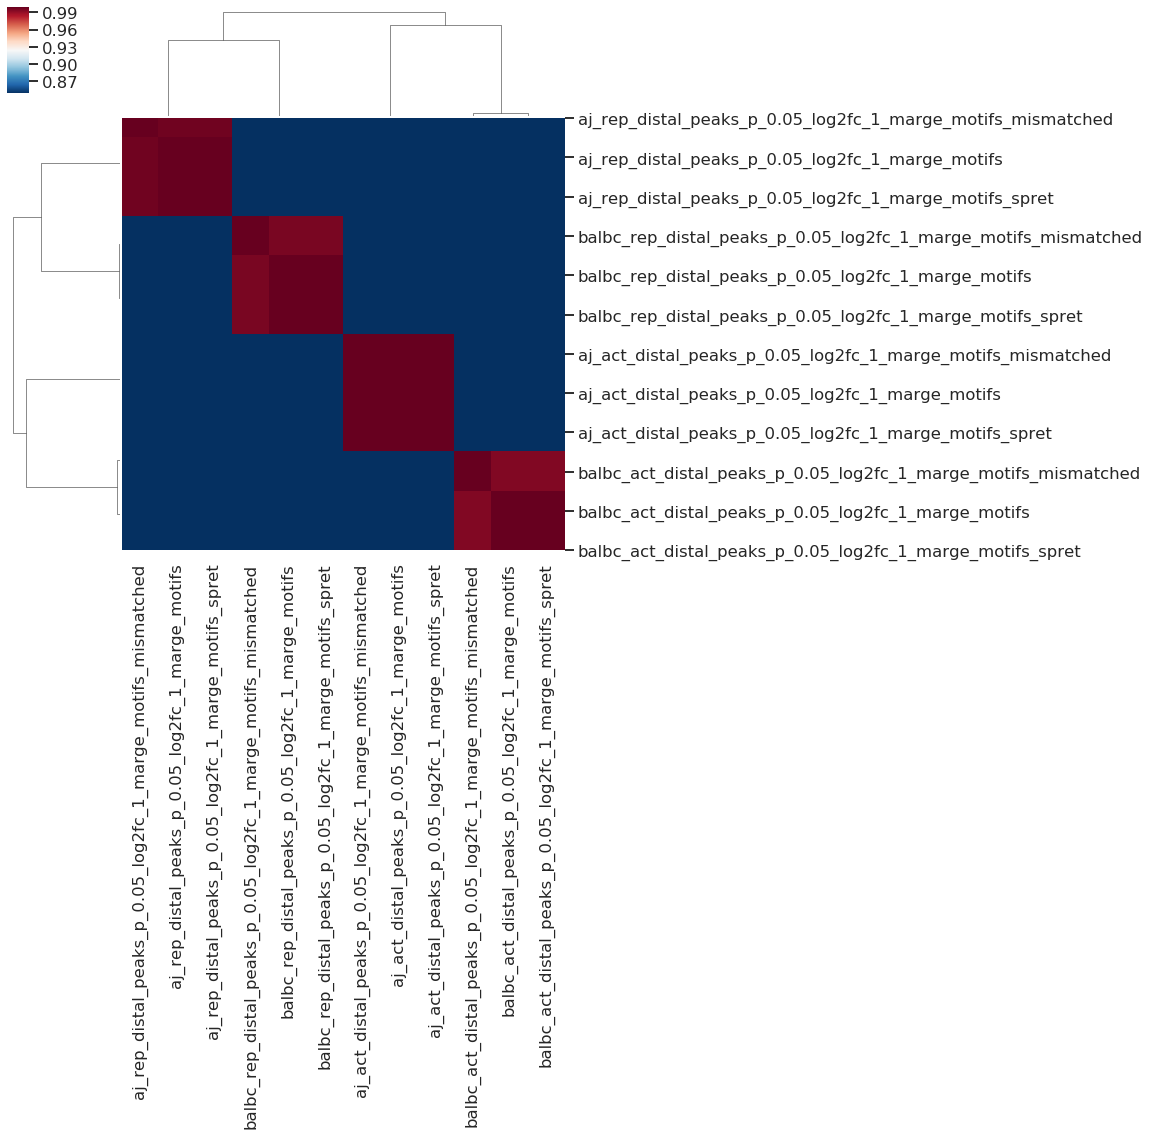

In [20]:
sns.clustermap(known_motif_pval_frame.corr(),
            cmap='RdBu_r',
            vmin=0.85)

In [28]:
peak_lists = ['./motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/aj_act_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/aj_rep_distal_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/aj_rep_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/balbc_act_distal_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/balbc_act_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/balbc_rep_distal_peaks_p_0.05_log2fc_1_marge_',
              './motif_calling/balbc_rep_peaks_p_0.05_log2fc_1_marge_motifs/']